Chlorophyll algorithms from ocean color remote sensing missions come in two flavors, semi-analytical and empirical. The latter type is typically a band ratio based polynomial regression model, obtained via least squares fitting. These model are usually more successful than their analytical counterparts and as a result are part of the operational algorithmic arsenal used by the Ocean Biology Processing Group at NASA Goddard. 

Here I will focus on the OC4 algorithm, part of the OCx family of empirical algorithms, which are  generally expressed as follows.
$$ log_{10}\left(chlor_a\right) = a_0 + \sum_{i=1}^{4}a_ilog_{10}\left(\frac{max\left(Rrs\left(\lambda_{blue}\right)\right)}{Rrs\left(\lambda_{green}\right)}\right)^i$$

For this exercise I will load a dataset that is as close as possible to the dataset used for the calculation of the coefficients of the OC4 polynomial (available [here](https://oceancolor.gsfc.nasa.gov/atbd/chlor_a/)) using a frequentist least squares regression.
I will then repeat the exercise using a bayesian regression approach, and explore the much richer information content of the inference results.

I created the dataset I will use here with a similar approach to that in an [earlier post](https://madhatter106.github.io/DataScienceCorner/posts/getting-nomadata-into-a-pandas-dataframe/), with the difference that the data used here was extracted from the NOMAD v.2 dataset to mimick as much as possible the data described in O'Reilly *et al.* (2000). The resulting coefficients may be somewhat different from those making up NASA's operational algorithm, but  

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import os
import matplotlib.pyplot as pl
import pymc3 as pm
import pandas as pd
import seaborn as sb
import pickle
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container {width:90% !important;}</style>"))

In [3]:
%matplotlib inline

Define algorithms:

In [94]:
ocxCoeffs = [0.3272, -2.9940, 2.7218, -1.2259, -0.5683]
def CI(rgb, rrs_rgb):
    r,g,b = rgb
    rrsR, rrsG, rrsB = rrs_rgb
    ci = rrsG - (rrsB + (g - b) / (r - b) * (rrsR - rrsB))
    return ci

def OCx(ocxRatio, coeffs=ocxCoeffs, lin=False):
    if lin:
        ocxRatio = np.log10(ocxRatio)
    poly = np.sum([coeffs[i] * np.power((ocxRatio), i)
                  for i in range(1, 5) ], axis=0)
    poly+=coeffs[0]
    chl = np.power(10,poly)
    return chl

def FitPoly(X,y, order=4, lin=False):
    """Function to confirm coefficients"""
    if lin:
        X = np.log10(X)
        y = np.log10(y)
    coeffs = np.polyfit(X,y,deg=order)
    return coeffs

In [6]:
dfHu = pd.read_pickle('./bayesianChl_stuff/dfSwfHuOcxCI_2012.pkl')

In [7]:
dfHu['maxBlue'] = dfHu.loc[:,['rrs443', 'rrs490', 'rrs510']].max(axis=1)
dfHu['OCx_ratio'] = dfHu.maxBlue/dfHu['rrs555']
dfHu.head()

,rrs411,rrs443,rrs489,rrs510,rrs555,rrs670,id,depth,hplc_chl,sst,lat,lon,maxBlue,OCx_ratio
364,0.000719,0.000948,0.001301,0.001324,0.001442,0.000172,7733,4579.0,0.762,28.01,9.8309,-54.0398,0.001324,0.917677
365,0.000668,0.000919,0.001278,0.001336,0.001442,0.000148,7734,4711.0,0.653,26.86,13.0033,-55.9705,0.001336,0.926762
366,0.000568,0.000890,0.001350,0.001396,0.001471,0.000164,7735,2815.0,0.674,27.61,8.4358,-55.6672,0.001396,0.948457
367,0.000180,0.000421,0.000861,0.000944,0.001034,0.000127,7736,305.0,0.781,27.28,7.5592,-54.1950,0.000944,0.913254
368,0.000744,0.001134,0.001620,0.001552,0.001356,0.000094,7737,3738.0,0.409,27.29,9.5839,-55.6653,0.001552,1.144766


In [8]:
dfHu.describe()

,rrs411,rrs443,rrs489,rrs510,rrs555,rrs670,id,depth,hplc_chl,sst,lat,lon,maxBlue,OCx_ratio
count,136.000000,136.000000,136.000000,136.000000,136.000000,136.000000,136.000000,136.000000,136.000000,136.000000,136.000000,136.000000,136.000000,136.000000
mean,0.005336,0.004684,0.004071,0.003217,0.002535,0.000594,6240.088235,2155.500000,1.942732,21.763382,12.399556,-72.949479,0.005098,2.582634
std,0.005361,0.003904,0.002099,0.001401,0.001920,0.001094,1922.935547,2018.518092,6.550881,6.950208,25.752077,52.987492,0.003684,2.317327
min,0.000051,0.000190,0.000422,0.000497,0.000639,0.000000,2640.000000,31.000000,0.017000,5.260000,-35.164400,-170.045000,0.000497,0.545438
25%,0.001404,0.001766,0.002409,0.002365,0.001568,0.000094,5903.750000,64.000000,0.145750,16.380000,-1.261000,-90.375800,0.002434,0.948665
50%,0.002839,0.002850,0.003435,0.003235,0.001857,0.000175,7226.500000,2809.500000,0.451500,25.625000,11.413400,-73.367600,0.003624,1.377884
75%,0.007855,0.007016,0.005809,0.003892,0.002625,0.000503,7314.000000,4305.750000,1.130750,27.290000,37.357600,-56.020225,0.007459,4.046750
max,0.022010,0.016246,0.009500,0.009600,0.012200,0.007900,7747.000000,5526.000000,53.002700,30.180000,43.619200,170.000000,0.016246,9.608322


In [9]:
dfHu.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 136 entries, 364 to 4201
Data columns (total 14 columns):
rrs411       136 non-null float64
rrs443       136 non-null float64
rrs489       136 non-null float64
rrs510       136 non-null float64
rrs555       136 non-null float64
rrs670       136 non-null float64
id           136 non-null int32
depth        136 non-null float64
hplc_chl     136 non-null float64
sst          136 non-null float64
lat          136 non-null float64
lon          136 non-null float64
maxBlue      136 non-null float64
OCx_ratio    136 non-null float64
dtypes: float64(13), int32(1)
memory usage: 15.4 KB


Let's first confirm, we get the right kind of coefficients

In [95]:
coefs = FitPoly(dfHu.OCx_ratio,dfHu.hplc_chl,lin=True)
print(coefs)
#ocxCoeffs = [0.3272, -2.9940, 2.7218, -1.2259, -0.5683]

[ 2.12047382 -7.02847525  6.14026526 -3.03548302  0.02915427]


Let's first confirm we're getting the plots right:    

In [10]:
ocxChl = OCx(dfHu.OCx_ratio,lin=True)

In [11]:
ci = CI([443,555,670],[dfHu.rrs443, dfHu.rrs555, dfHu.rrs670])
ciChl = np.power(10, -0.4909+191.6590 * ci)

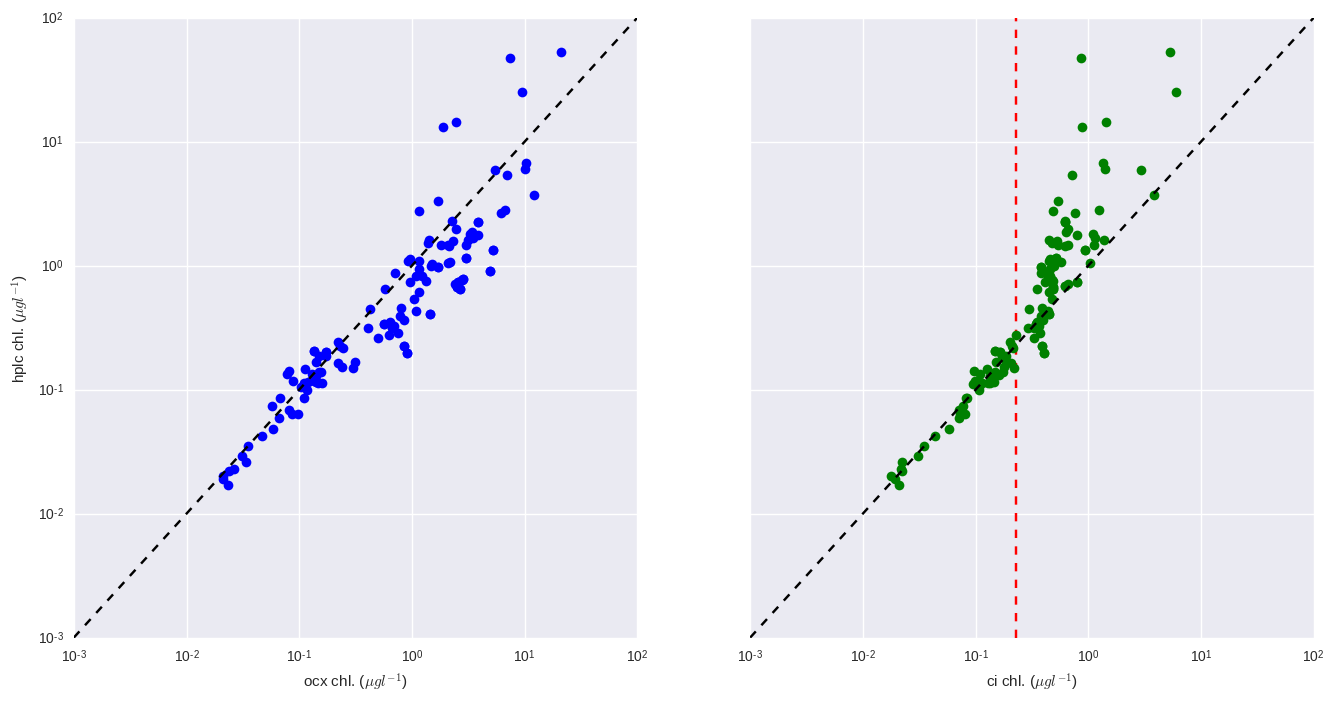

In [12]:
f,axs = pl.subplots(ncols=2, figsize=(16,8),sharey=True)
axs[0].loglog(ocxChl,dfHu.hplc_chl.values,'bo')
axs[0].loglog([1e-3, 1e2], [1e-3, 1e2], 'k--')
axs[0].set_ylabel('hplc chl. ($\mu gl^{-1}$)')
axs[0].set_xlabel('ocx chl. ($\mu gl^{-1}$)')
axs[1].loglog(ciChl, dfHu.hplc_chl.values, 'go')
axs[1].vlines(ciChl[ci<=-5e-4].max(),1e-3, 1e2,'r',linestyles='--', label='ci threshold($-5e^{-4}$)')
axs[1].loglog([1e-3, 1e2], [1e-3, 1e2], 'k--')
axs[1].set_xlabel('ci chl. ($\mu g l^{-1}$)')

Metrics for OCx

In [13]:
print("mse: %.2f " % mean_squared_error(dfHu.hplc_chl.values,ocxChl))
print(r"r^2: %.2f" % r2_score(dfHu.hplc_chl.values,ocxChl))

mse: 24.91 
r^2: 0.42


Hu *et al.* claims an $R^2$ of $0.95$ for CI-predicted Chl when CI $\leq -5e^{-4}$ while OC4 gave a 0.85 $R^2$ for the same points. a $-5e^{-4} corresponds ~ 4 $mg m^{-3} chl.

In [14]:
np.where(ci<=-5e-4,True,False).sum()

50

In [15]:
ciChl[ci<=-5e-4].max()

0.22867525333633054

In [16]:
dfHuLog = dfHu
dfHuLog = dfHu[['OCx_ratio', 'hplc_chl']].apply(lambda x: np.log10(x))

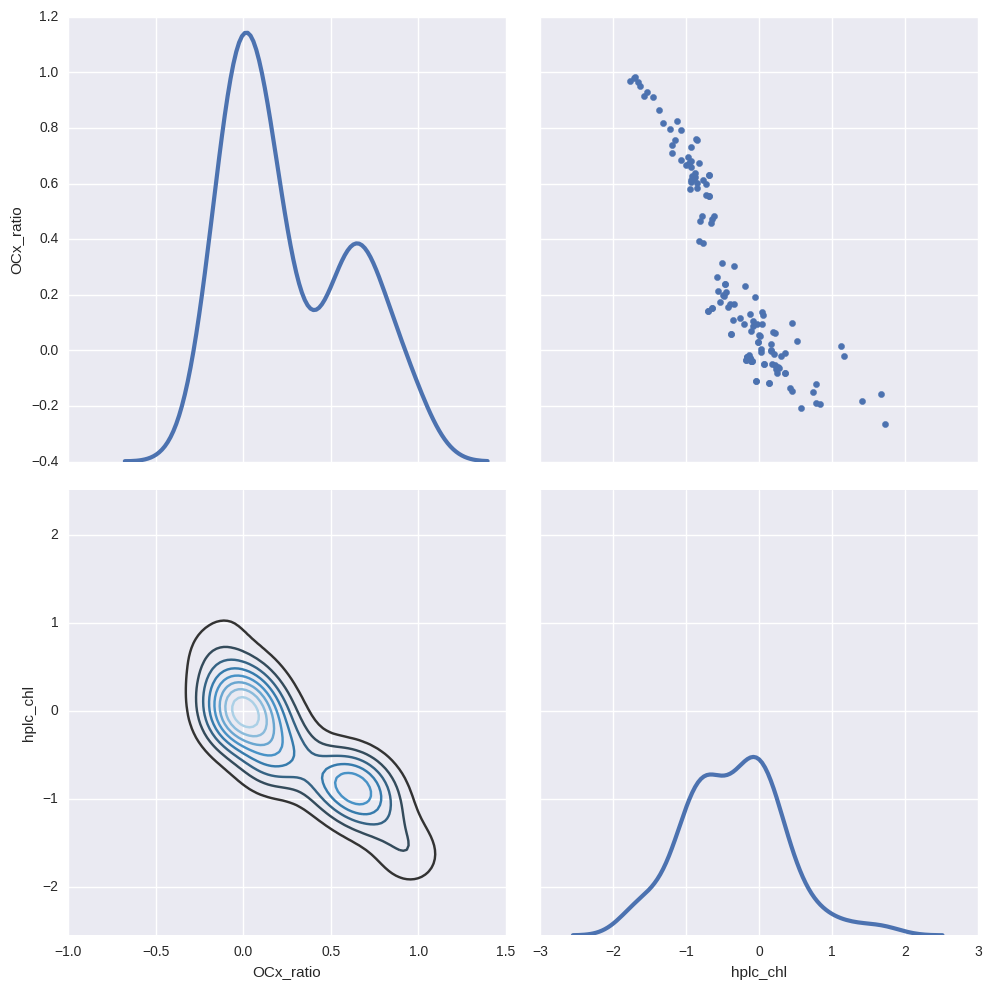

In [17]:
pg = sb.PairGrid(dfHuLog,size=5)
pg = pg.map_upper(pl.scatter)
pg = pg.map_lower(sb.kdeplot, cmap="Blues_d")
pg = pg.map_diag(sb.kdeplot, lw=3, legend=False)

Can we assume that transformed chl (log) is normally distributed. Next I check the normality, based on an approach that is actually practical (unlike Kolmogorov-Smirnov test), explained [here](http://allendowney.blogspot.com/2013/08/are-my-data-normal.html).

In [29]:
from scipy.stats import norm, t

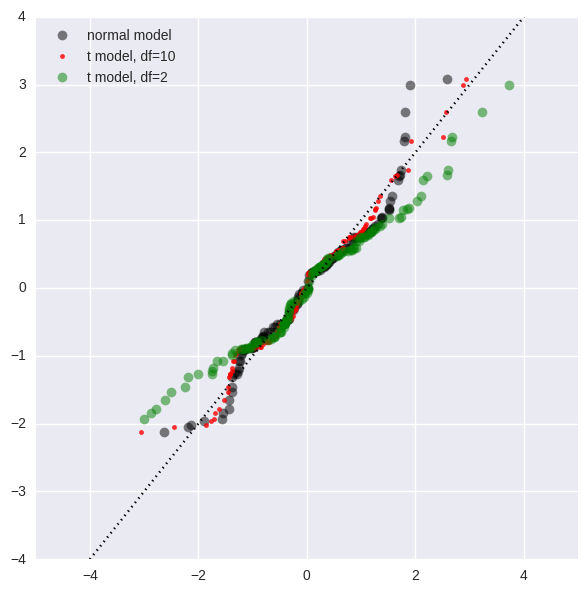

In [77]:
df1,df2 = 10,2
normData = norm.rvs(0,1,size=dfHuLog.shape[0])
tData1 = t.rvs(df1,size=dfHuLog.shape[0])
tData2 = t.rvs(df2, size=dfHuLog.shape[0])
normDataSort = np.sort(normData)
tDataSort1 = np.sort(tData1)
tDataSort2 = np.sort(tData2)
logChlSort = np.sort(dfHuLog.hplc_chl.values)
stdLogChl  = (logChlSort - logChlSort.mean()) / logChlSort.std()
pl.figure(figsize=(7,7))
pl.plot(normDataSort, stdLogChl,'ko', alpha=0.5, label='normal model')
pl.plot(tDataSort1,stdLogChl, 'r.', alpha=0.8, label='t model, df=%d' % df1)
pl.plot(tDataSort2, stdLogChl, 'go', alpha=0.5, label='t model, df=%d' % df2)
pl.plot([-4,4],[-4,4], 'k:')
pl.legend(loc='best')
pl.xlim((-5,5));

The above suggests that a normal distribution might be a good candidate to apply to the likelihood. A slightly better option may be a t-distribution with a relatively high degree of freedom.

In [28]:
dfHuLog.describe()

,OCx_ratio,hplc_chl
count,136.000000,136.000000
mean,0.264563,-0.342740
std,0.346724,0.674366
min,-0.263255,-1.769551
25%,-0.022887,-0.836440
50%,0.139207,-0.345349
75%,0.607095,0.053355
max,0.982648,1.724298


In [78]:
loChlCount = dfHuLog.loc[dfHuLog.hplc_chl<np.log10(0.25)].count()
hiChlCount = dfHuLog.loc[dfHuLog.hplc_chl>=np.log10(0.25),:].shape[0]

In [79]:
loChlCount, hiChlCount

(OCx_ratio    53
 hplc_chl     53
 dtype: int64, 83)

In [80]:
ocxRatio = dfHuLog.OCx_ratio
chlObs = dfHuLog.hplc_chl

In [81]:
with pm.Model() as model_OCx:
    a0 = pm.Normal('a0', mu=0, sd=10)
    a1 = pm.Normal('a1', mu=0, sd=10)
    a2 = pm.Normal('a2', mu=0, sd=10)
    a3 = pm.Normal('a3', mu=0, sd=10)
    a4 = pm.Normal('a4', mu=0, sd=10)
    epsilon = pm.Uniform('epsilon', lower=0, upper=10)
    mu = a0 + a1 * ocxRatio + a2 * ocxRatio**2 + a3 * ocxRatio**3 + a4 * ocxRatio**4
    chlPred = pm.Normal('chlPred', mu=mu, sd=epsilon, observed=chlObs)
    start = pm.find_MAP()
    step = pm.NUTS(scaling=start)
    traceOCx = pm.sample(10000, step=step, start=start)

Optimization terminated successfully.
         Current function value: 28.968937
         Iterations: 22
         Function evaluations: 32
         Gradient evaluations: 32


100%|██████████| 10000/10000 [02:47<00:00, 59.86it/s]


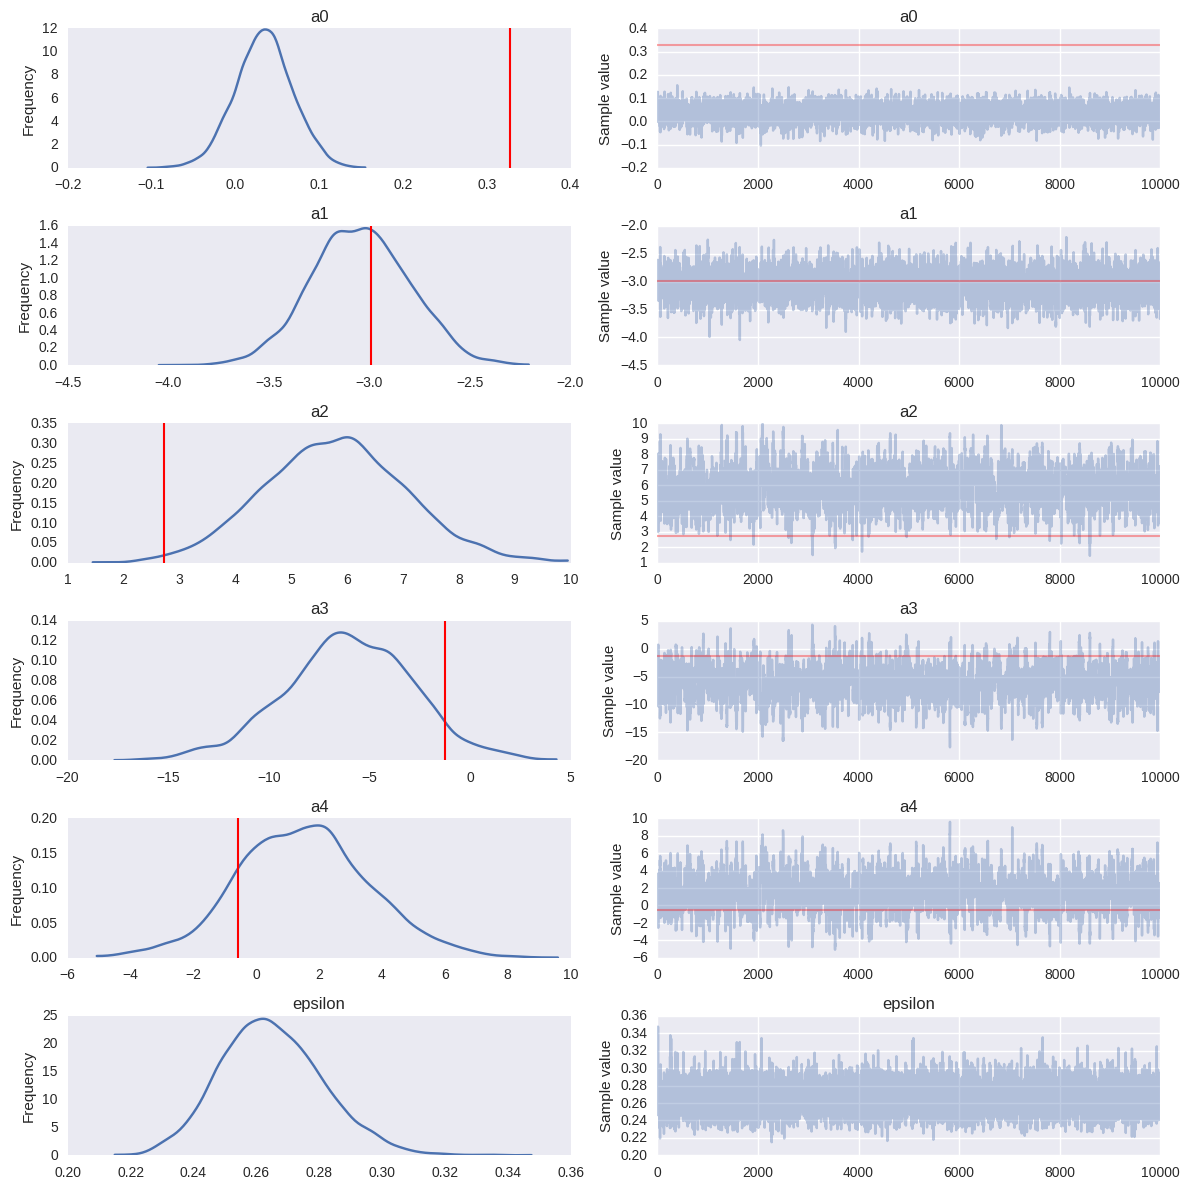

In [82]:
chainOCx = traceOCx[1000:]
varnames=['a%d' %d for d in range(5)]
varnames.append('epsilon')
refvals = {'a%d' %d: rv for d,rv in zip(range(5), ocxCoeffs) }
pm.traceplot(traceOCx,varnames=varnames,lines=refvals);

In [83]:
pm.df_summary(chainOCx, varnames=varnames)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
a0,0.033664,0.034238,0.000737,-0.032777,0.101661
a1,-3.048195,0.245595,0.004229,-3.532009,-2.588758
a2,5.795483,1.275771,0.043453,3.401550,8.441150
a3,-6.094117,3.189521,0.115439,-13.061492,-0.040899
a4,1.525246,2.100381,0.074018,-2.459339,6.045975
epsilon,0.265122,0.016184,0.000213,0.234210,0.297684


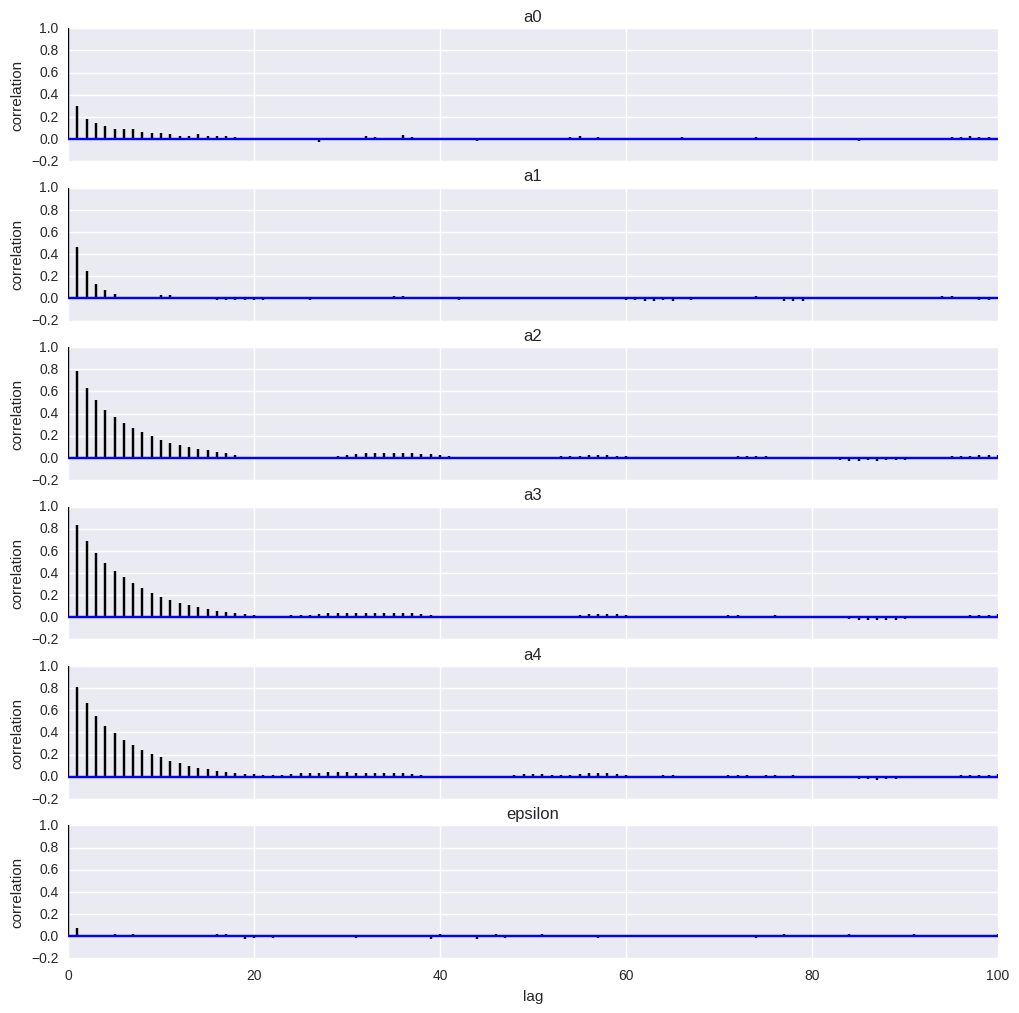

In [84]:
pm.autocorrplot(chainOCx, varnames=varnames);

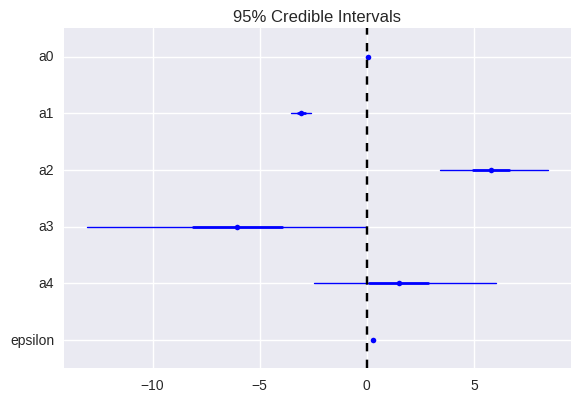

In [85]:
pm.forestplot(chainOCx,varnames=varnames)

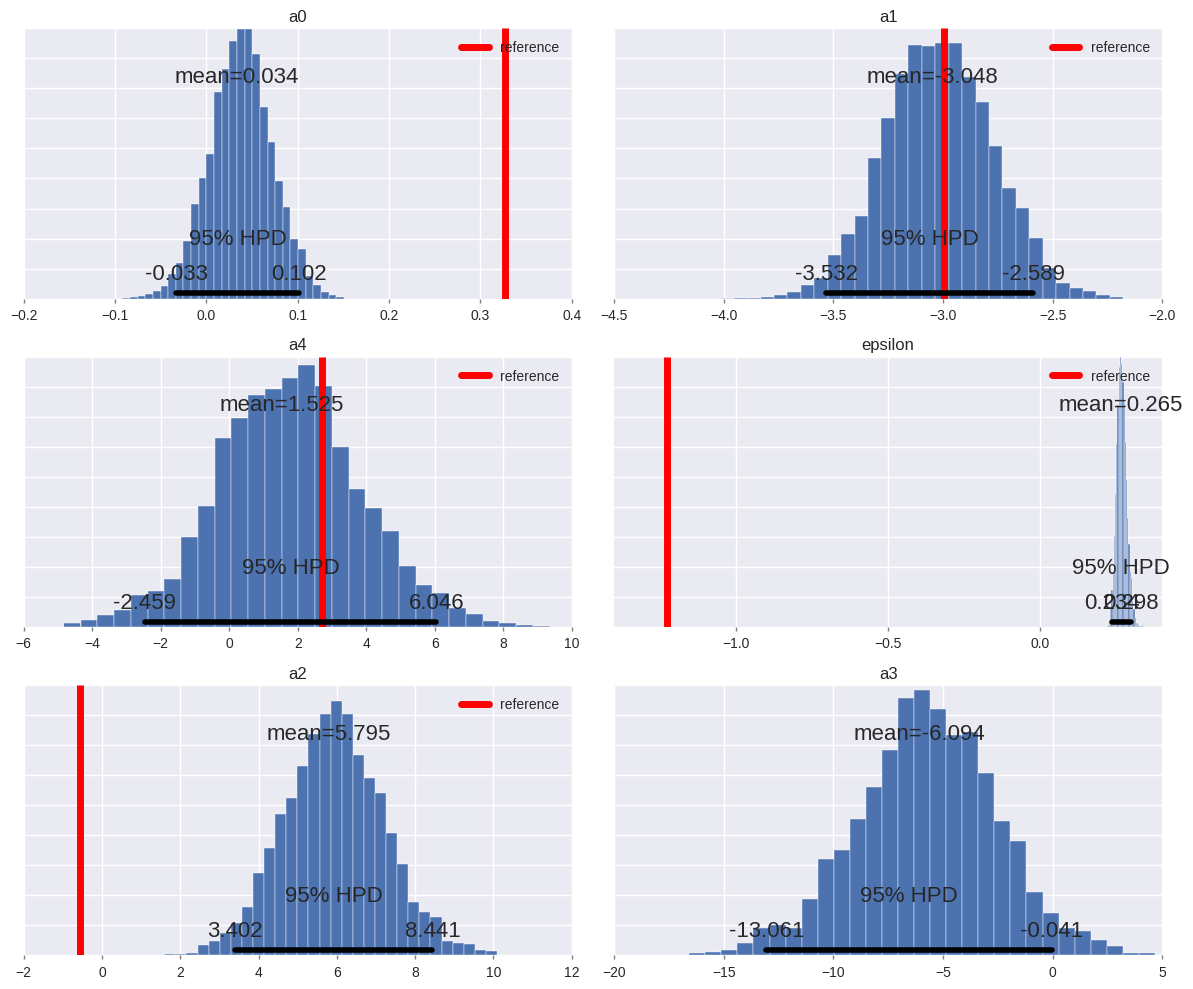

In [86]:
axs=pm.plot_posterior(chainOCx,varnames=varnames, figsize=(12,10))
for ax,rv in zip(axs.ravel(),ocxCoeffs):
    ax.vlines(rv,0,ax.get_ylim()[1], colors='r', linewidth=5, label='reference')
    ax.legend()

In [96]:
chlModl=0
ocxRatioMock = np.linspace(ocxRatio.min(),ocxRatio.max(),100)
for i in range(5):
    chlModl+= ocxCoeffs[i]*ocxRatioMock**i

In [97]:
chlBayes=0
p = np.poly1d(coefs)
for i in range(5):
    chlBayes += chainOCx['a%d' %i].mean()*ocxRatioMock**i
    chlLsq = p(ocxRatioMock)

In [89]:
idx = np.argsort(ocxRatio.values)
ocxRatio_ord = ocxRatio.values[idx]
ppc = pm.sample_ppc(chainOCx, samples=1000, model=model_OCx)
sig0 = pm.hpd(ppc['chlPred'], alpha=0.5)[idx]
sig1 = pm.hpd(ppc['chlPred'], alpha=0.05)[idx]

100%|██████████| 1000/1000 [00:28<00:00, 35.51it/s]


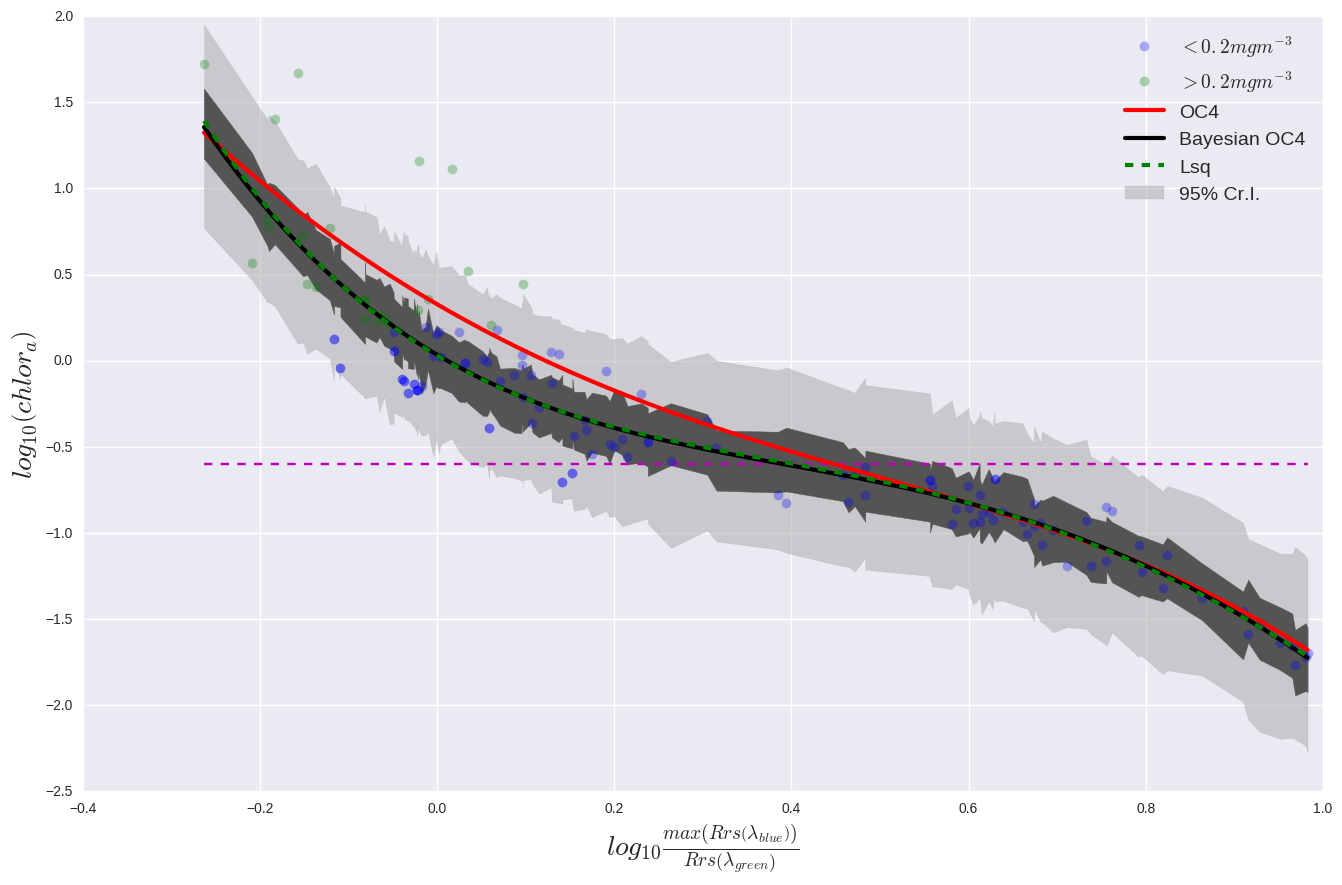

In [99]:
pl.figure(figsize=(16,10))
pl.fill_between(ocxRatio_ord, sig0[:,0], sig0[:,1], color='k', alpha=1)
pl.fill_between(ocxRatio_ord, sig1[:,0], sig1[:,1], color='darkgray', alpha=0.5, label='95% Cr.I.')
pl.plot(ocxRatio[chlObs<=.2],chlObs[chlObs<=.2],'bo',alpha=0.3, label='$<0.2mg m^{-3}$')
pl.plot(ocxRatio[chlObs>.2],chlObs[chlObs>.2],'go',alpha=0.3, label='$>0.2mg m^{-3}$')
pl.plot(ocxRatioMock,chlModl,'r', linewidth=3, label='OC4')
pl.plot(ocxRatioMock,chlBayes,'k', linewidth=3, label='Bayesian OC4')
pl.plot(ocxRatioMock,chlLsq,'g', linewidth=3, linestyle='--', label='Lsq')
pl.hlines(np.log10(0.25),ocxRatioMock.min(),ocxRatioMock.max(),'m','--')
pl.xlabel(r'$log_{10}\frac{max(Rrs\left(\lambda_{blue}\right))}{Rrs\left(\lambda_{green}\right)}$', fontsize=20)
pl.ylabel(r'$log_{10}\left(chlor_a\right)$', fontsize=20);
pl.legend(fontsize=14);

Let's calculate metrics for this model

In [101]:
chlBayesReal=0
for i in range(5):
    chlBayesReal += chainOCx['a%d' %i].mean()*ocxRatio**i
chlBayesReal = np.power(10, chlBayesReal)

In [102]:
print("OCx Chl mse: %.2f " % mean_squared_error(dfHu.hplc_chl.values,ocxChl))
print("Bayes Chl mse: %.2f" % mean_squared_error(dfHu.hplc_chl.values,chlBayesReal))
print("OCx Chl r^2: %.2f" % r2_score(dfHu.hplc_chl.values,ocxChl))
print("Bayes Chl r^2: %.2f" % r2_score(dfHu.hplc_chl.values, chlBayesReal))

OCx Chl mse: 24.91 
Bayes Chl mse: 25.31
OCx Chl r^2: 0.42
Bayes Chl r^2: 0.41


In [103]:
print("OCx Chl mse: %.2f " % mean_squared_error(-1*dfHu.hplc_chl.values,-1*ocxChl))
print("Bayes Chl mse: %.2f" % mean_squared_error(-1*dfHu.hplc_chl.values,-1*chlBayesReal))
print("OCx Chl r^2: %.2f" % r2_score(-1*dfHu.hplc_chl.values,-1*ocxChl))
print("Bayes Chl r^2: %.2f" % r2_score(-1*dfHu.hplc_chl.values, -1*chlBayesReal))

OCx Chl mse: 24.91 
Bayes Chl mse: 25.31
OCx Chl r^2: 0.42
Bayes Chl r^2: 0.41


What about for low values, how is that performing, e.g. relative to ci CHl?
What about a test set how do both models compare on an unseen dataset?

In [ ]:
from IPython.core.display import HTML
def css_styling():
    styles = open("../styles/custom.css", "r").read()
    return HTML(styles)
css_styling()